In [1]:
pip install tensorflow numpy matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold
from keras.regularizers import l2
from keras.initializers import HeNormal
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

2024-07-07 19:42:48.122351: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-07 19:42:48.239195: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-07 19:42:48.388331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 19:42:48.527575: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 19:42:48.528410: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-07 19:42:48.735695: I tensorflow/core/platform/cpu_feature_guard.cc:

In [3]:
import os
import shutil
import random

def clear_directory(directory):
    """
    Elimina todos los archivos en un directorio.
    
    Args:
    directory (str): El directorio a limpiar.
    """
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f'Error al borrar el archivo {file_path}. Motivo: {e}')


def split_data(source, training, validation, split_size):
    """
    Divide las imágenes en carpetas de entrenamiento y validación.
    
    Args:
    source (str): Directorio que contiene todas las imágenes.
    training (str): Directorio para las imágenes de entrenamiento.
    validation (str): Directorio para las imágenes de validación.
    split_size (float): Proporción de las imágenes que irán al conjunto de entrenamiento.
    """
    # Limpiar los directorios de destino
    clear_directory(training)
    clear_directory(validation)
    
    all_files = []
    for file_name in os.listdir(source):
        file_path = os.path.join(source, file_name)
        if os.path.isfile(file_path):  # Asegurarse de que es un archivo y no un directorio
            if os.path.getsize(file_path) > 0:
                all_files.append(file_name)
            else:
                print(f"{file_name} está vacío, por lo que no será considerado.")
        else:
            print(f"{file_name} es un directorio y será ignorado.")
    
    random.shuffle(all_files)
    split_index = int(len(all_files) * split_size)
    
    training_files = all_files[:split_index]
    validation_files = all_files[split_index:]
    
    for file_name in training_files:
        src_path = os.path.join(source, file_name)
        dest_path = os.path.join(training, file_name)
        shutil.copyfile(src_path, dest_path)
    
    for file_name in validation_files:
        src_path = os.path.join(source, file_name)
        dest_path = os.path.join(validation, file_name)
        shutil.copyfile(src_path, dest_path)

In [4]:
# Definir rutas
base_dir = 'dataset'
source_galaxy_dir = os.path.join(base_dir, 'galaxy_images')
source_no_galaxy_dir = os.path.join(base_dir, 'no_galaxy_images')

train_galaxy_dir = os.path.join(base_dir, 'train/galaxy')
validation_galaxy_dir = os.path.join(base_dir, 'validation/galaxy')
train_no_galaxy_dir = os.path.join(base_dir, 'train/no_galaxy')
validation_no_galaxy_dir = os.path.join(base_dir, 'validation/no_galaxy')

In [5]:
# Crear directorios de destino si no existen
os.makedirs(train_galaxy_dir, exist_ok=True)
os.makedirs(validation_galaxy_dir, exist_ok=True)
os.makedirs(train_no_galaxy_dir, exist_ok=True)
os.makedirs(validation_no_galaxy_dir, exist_ok=True)

In [14]:
# Dividir los datos
split_size = 0.8  # Proporción de datos para entrenamiento
split_data(source_galaxy_dir, train_galaxy_dir, validation_galaxy_dir, split_size)
split_data(source_no_galaxy_dir, train_no_galaxy_dir, validation_no_galaxy_dir, split_size)

.ipynb_checkpoints es un directorio y será ignorado.
.ipynb_checkpoints es un directorio y será ignorado.


In [15]:
# Definir rutas a los directorios
train_dir = 'dataset/train'
validation_dir = 'dataset/validation'

# Crear generadores de datos
train_datagen = ImageDataGenerator(rescale=1.0/255)
validation_datagen = ImageDataGenerator(rescale=1.0/255)

# Cargar datos de entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

# Cargar datos de validación
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

Found 1083 images belonging to 2 classes.
Found 271 images belonging to 2 classes.


In [21]:
# Modelo inicial: simple y básico
model_simple = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_simple.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

model_simple.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 63504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     4,064,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,064,833 (15.51 MB)

 Trainable params: 4,064,833 (15.51 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Modelo intermedio: más profundidad y regularización inicial
model_medio = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),  # Menos dropout que en el modelo final
    Dense(1, activation='sigmoid')
])

model_intermediate.compile(optimizer='adam',
                           loss='binary_crossentropy',
                           metrics=['accuracy'])

model_intermediate.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,449 (28.20 MB)

 Trainable params: 7,392,449 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,329 (49.36 MB)

 Trainable params: 12,939,329 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20
)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 344ms/step - accuracy: 0.6885 - loss: 0.5941 - val_accuracy: 0.8867 - val_loss: 0.2915
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7812 - loss: 0.4305 - val_accuracy: 0.8667 - val_loss: 0.2189
Epoch 3/20


2024-07-07 21:49:23.113945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 21:49:23.141689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 326ms/step - accuracy: 0.8809 - loss: 0.2920 - val_accuracy: 0.9102 - val_loss: 0.2214
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9062 - loss: 0.2481 - val_accuracy: 1.0000 - val_loss: 0.0293
Epoch 5/20


2024-07-07 21:49:35.470211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 21:49:35.497007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 330ms/step - accuracy: 0.9255 - loss: 0.1804 - val_accuracy: 0.9414 - val_loss: 0.1456
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0906 - val_accuracy: 0.8000 - val_loss: 0.1887
Epoch 7/20


2024-07-07 21:49:47.830370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 21:49:47.856138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 329ms/step - accuracy: 0.9639 - loss: 0.1017 - val_accuracy: 0.9375 - val_loss: 0.1283
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9375 - loss: 0.1062 - val_accuracy: 0.8667 - val_loss: 0.2029
Epoch 9/20


2024-07-07 21:50:00.132011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 21:50:00.157428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 329ms/step - accuracy: 0.9737 - loss: 0.0681 - val_accuracy: 0.9062 - val_loss: 0.1743
Epoch 10/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9688 - loss: 0.2322 - val_accuracy: 0.8667 - val_loss: 0.2956
Epoch 11/20


2024-07-07 21:50:12.432889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 21:50:12.459289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 335ms/step - accuracy: 0.9781 - loss: 0.0620 - val_accuracy: 0.9336 - val_loss: 0.1428
Epoch 12/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9375 - loss: 0.1056 - val_accuracy: 0.8667 - val_loss: 0.2335
Epoch 13/20


2024-07-07 21:50:24.962342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 21:50:24.986938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 336ms/step - accuracy: 0.9787 - loss: 0.0549 - val_accuracy: 0.9492 - val_loss: 0.1210
Epoch 14/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9688 - loss: 0.0640 - val_accuracy: 1.0000 - val_loss: 0.0406
Epoch 15/20


2024-07-07 21:50:37.445343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 21:50:37.471619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 336ms/step - accuracy: 0.9919 - loss: 0.0310 - val_accuracy: 0.9023 - val_loss: 0.2811
Epoch 16/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0149 - val_accuracy: 0.8667 - val_loss: 0.6422
Epoch 17/20


2024-07-07 21:50:50.053106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 21:50:50.077334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 328ms/step - accuracy: 0.9797 - loss: 0.0779 - val_accuracy: 0.9180 - val_loss: 0.1667
Epoch 18/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9688 - loss: 0.1124 - val_accuracy: 0.8667 - val_loss: 0.4159
Epoch 19/20


2024-07-07 21:51:02.328220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 21:51:02.353299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 328ms/step - accuracy: 0.9867 - loss: 0.0397 - val_accuracy: 0.9102 - val_loss: 0.1824
Epoch 20/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0202 - val_accuracy: 1.0000 - val_loss: 0.0432


2024-07-07 21:51:14.567621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 21:51:14.593936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [40]:
# Evaluar el modelo en el conjunto de validación
loss, accuracy = model.evaluate(validation_generator)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.9146 - loss: 0.1728
Loss: 0.17583145201206207
Accuracy: 0.9151291251182556


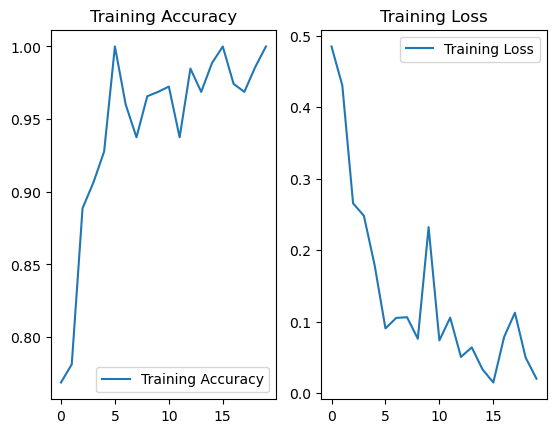

In [41]:
# Graficar precisión y pérdida solo para el conjunto de entrenamiento
acc = history.history['accuracy']
loss = history.history['loss']

epochs_range = range(len(acc))

#plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')

plt.show()

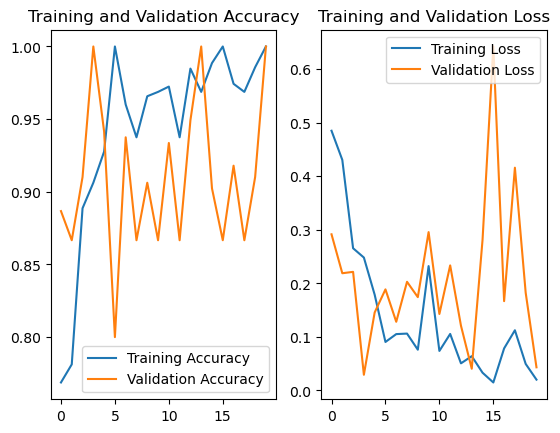

In [42]:
# Graficar precisión y pérdida
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
#Guardamos el modelo
#model.save('galaxy_classifier_model.keras')

In [14]:
model = Sequential([
    # Aumentamos el tamaño del kernel y agregamos padding para mantener el tamaño de la imagen
    Conv2D(32, (5, 5), activation='relu', input_shape=(128, 128, 3), padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),  # Añadimos normalización por lotes para mejorar la estabilidad del entrenamiento
    Conv2D(64, (5, 5), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Conv2D(128, (5, 5), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),  # Añadimos regularización L2 para reducir el sobreajuste
    Dropout(0.4),  # Ajustamos la tasa de dropout para ver si mejora el aprendizaje
    Dense(1, activation='sigmoid')
])

In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,037,761 (64.99 MB)

 Trainable params: 17,037,313 (64.99 MB)

 Non-trainable params: 448 (1.75 KB)

In [16]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=15
)

Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 660ms/step - accuracy: 0.7565 - loss: 3.8415 - val_accuracy: 0.6953 - val_loss: 2.2384
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9062 - loss: 1.9826 - val_accuracy: 0.8000 - val_loss: 1.7185
Epoch 3/15


2024-07-06 13:11:07.413639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-06 13:11:07.512020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 694ms/step - accuracy: 0.8953 - loss: 1.9381 - val_accuracy: 0.6836 - val_loss: 3.1882
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9375 - loss: 1.6212 - val_accuracy: 0.8000 - val_loss: 2.4047
Epoch 5/15


2024-07-06 13:11:33.019991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-06 13:11:33.119271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 556ms/step - accuracy: 0.9240 - loss: 1.5873 - val_accuracy: 0.6797 - val_loss: 2.8320
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9062 - loss: 1.3957 - val_accuracy: 0.8667 - val_loss: 2.1672
Epoch 7/15


2024-07-06 13:11:53.254239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-06 13:11:53.350903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 546ms/step - accuracy: 0.9530 - loss: 1.4080 - val_accuracy: 0.6953 - val_loss: 2.4028
Epoch 8/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8750 - loss: 1.8192 - val_accuracy: 0.6000 - val_loss: 2.8964
Epoch 9/15


2024-07-06 13:12:12.996611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-06 13:12:13.087614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 543ms/step - accuracy: 0.9785 - loss: 1.2045 - val_accuracy: 0.7539 - val_loss: 2.0855
Epoch 10/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9688 - loss: 1.2793 - val_accuracy: 0.7333 - val_loss: 2.3562
Epoch 11/15


2024-07-06 13:12:32.694380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-06 13:12:32.782884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 544ms/step - accuracy: 0.9732 - loss: 1.1339 - val_accuracy: 0.6875 - val_loss: 2.6465
Epoch 12/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.9464 - val_accuracy: 0.7333 - val_loss: 2.0269
Epoch 13/15


2024-07-06 13:12:52.435984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-06 13:12:52.524062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 538ms/step - accuracy: 0.9721 - loss: 1.0054 - val_accuracy: 0.6992 - val_loss: 3.5084
Epoch 14/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.8686 - val_accuracy: 0.5333 - val_loss: 4.2698
Epoch 15/15


2024-07-06 13:13:11.972683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-06 13:13:12.059871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 543ms/step - accuracy: 0.9735 - loss: 0.9056 - val_accuracy: 0.7031 - val_loss: 3.1257


In [17]:
# Evaluar el modelo en el conjunto de validación
loss, accuracy = model.evaluate(validation_generator)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.7098 - loss: 3.1471
Loss: 3.114400625228882
Accuracy: 0.7011070251464844


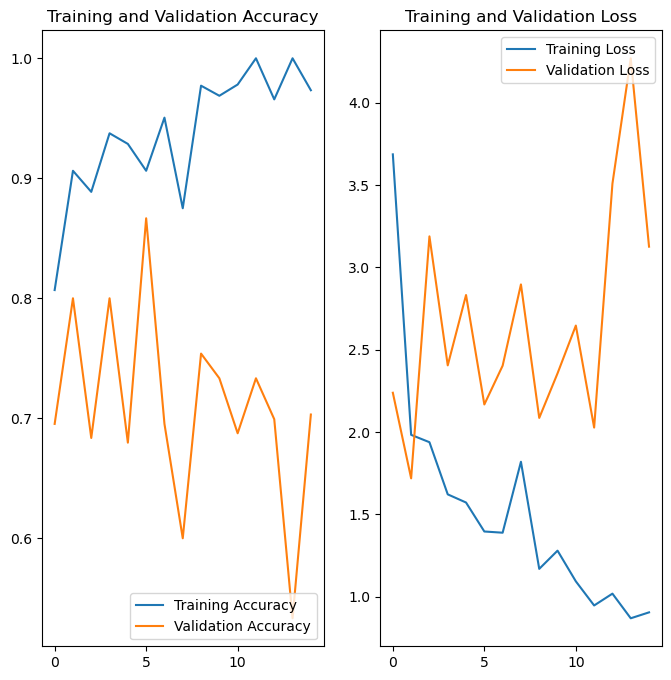

In [18]:
# Graficar precisión y pérdida
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_initializer=HeNormal()),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer=HeNormal()),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_initializer=HeNormal()),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),  # Reducida la tasa de dropout
    Dense(1, activation='sigmoid')
])

# Usar un optimizador Adam con una tasa de aprendizaje ligeramente modificada
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,329 (49.36 MB)

 Trainable params: 12,939,329 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=15
)

Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 317ms/step - accuracy: 0.6073 - loss: 6.5492 - val_accuracy: 0.8711 - val_loss: 0.3544
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8125 - loss: 0.3533 - val_accuracy: 0.8000 - val_loss: 0.3715
Epoch 3/15


2024-07-06 13:13:46.707566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-06 13:13:46.732424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 307ms/step - accuracy: 0.8682 - loss: 0.3074 - val_accuracy: 0.9180 - val_loss: 0.2225
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8438 - loss: 0.3076 - val_accuracy: 1.0000 - val_loss: 0.0932
Epoch 5/15


2024-07-06 13:13:58.242030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-06 13:13:58.266047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 311ms/step - accuracy: 0.9427 - loss: 0.1477 - val_accuracy: 0.9492 - val_loss: 0.1608
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9375 - loss: 0.1240 - val_accuracy: 1.0000 - val_loss: 0.0889
Epoch 7/15


2024-07-06 13:14:09.949836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-06 13:14:09.973834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 305ms/step - accuracy: 0.9420 - loss: 0.1334 - val_accuracy: 0.9414 - val_loss: 0.1389
Epoch 8/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9688 - loss: 0.0368 - val_accuracy: 0.9333 - val_loss: 0.1440
Epoch 9/15


2024-07-06 13:14:21.393897: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-06 13:14:21.417642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 307ms/step - accuracy: 0.9577 - loss: 0.1078 - val_accuracy: 0.9570 - val_loss: 0.1131
Epoch 10/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 1.0000 - loss: 0.0278 - val_accuracy: 0.8000 - val_loss: 0.2302
Epoch 11/15


2024-07-06 13:14:32.916213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-06 13:14:32.939581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 300ms/step - accuracy: 0.9814 - loss: 0.0557 - val_accuracy: 0.9531 - val_loss: 0.1193
Epoch 12/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - accuracy: 0.9688 - loss: 0.1506 - val_accuracy: 0.9333 - val_loss: 0.1776
Epoch 13/15


2024-07-06 13:14:44.233017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-06 13:14:44.255601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 314ms/step - accuracy: 0.9779 - loss: 0.0596 - val_accuracy: 0.9414 - val_loss: 0.1084
Epoch 14/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0478 - val_accuracy: 0.9333 - val_loss: 0.1169
Epoch 15/15


2024-07-06 13:14:56.143947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-06 13:14:56.167588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 312ms/step - accuracy: 0.9922 - loss: 0.0390 - val_accuracy: 0.9336 - val_loss: 0.1528


In [22]:
# Evaluar el modelo en el conjunto de validación
loss, accuracy = model.evaluate(validation_generator)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.9212 - loss: 0.1821
Loss: 0.15013141930103302
Accuracy: 0.9335793256759644


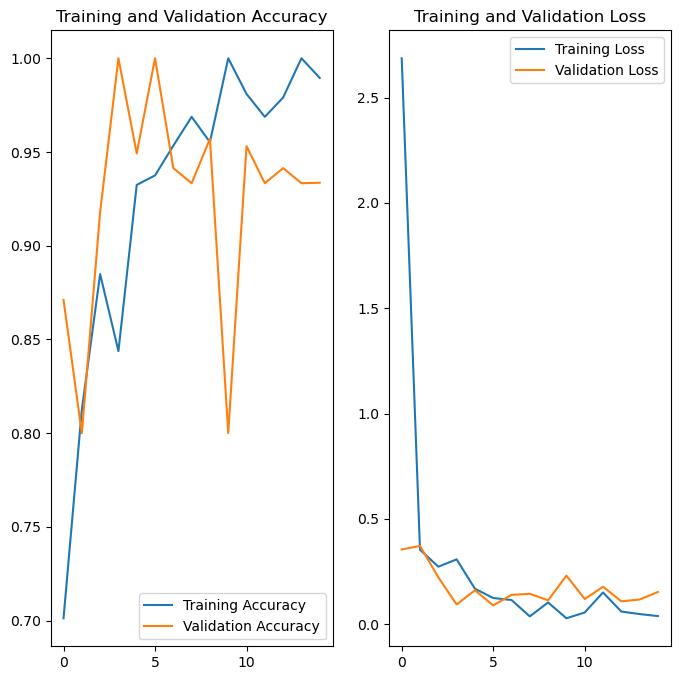

In [23]:
# Graficar precisión y pérdida
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()